In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import spatial
import nevergrad as ng
from sklearn.decomposition import PCA
import json
from es.utils.visualize import label_point, draw_pts
from es.utils.DataProcessor import paramsDict2Array
# %matplotlib ipympl
# %matplotlib inline

In [113]:
# %matplotlib ipympl
# plt.rcParams["figure.figsize"] = (12, 8)
%matplotlib inline
plt.rcParams["figure.figsize"] = (30, 15)

# Import Data

## set experiment parameters

In [3]:
# #  1, 2, 3, 5
# param_dict = {
#     0: 'speed',
#     1: 'max_curvature',
#     2: 'similarity',
#     3: 'follow_optim',
#     4: 'abs_speed_reward',
#     5: 'curvature_speed_punish',
#     6: 'opponent_collision'
# }
objective_dict = {0: 'progress', 1: 'agressive', 2:'safety'}
show_objective = {0, 1}

# 4
# param_dict = {
#     0: 'speed',
#     1: 'max_curvature',
#     2: 'length',
#     3: 'similarity',
#     4: 'follow_optim',
#     5: 'abs_speed_reward',
#     6: 'curvature_speed_punish',
#     7: 'opponent_collision'
# }
#
# # v2
# param_dict = {
#     0: 'speed',
#     1: 'max_curvature',
#     2: 'length',
#     3: 'similarity',
#     4: 'follow_optim',
#     5: 'abs_speed_reward',
#     6: 'curvature_speed_punish',
#     7: 'opponent_collision',
#     8: 'collision thres'
# }

In [4]:
# tmp, after the param_dict is stored in the config
param_dict = {
    0: 'speed',
    1: 'max_curvature',
    2: 'length',
    3: 'similarity',
    4: 'follow_optim',
    5: 'abs_speed_reward',
    6: 'curvature_speed_punish',
    7: 'opponent_collision',
    8: 'collision thres'
}
param_name_list = [
    "traj_v_scale",
    "cost_weights",
    "collision_thres"
  ]

## set run/epoch

In [90]:
# data_module = os.path.abspath('../data')
store_dir = 'data'
inside = False
if inside:
    data_module = os.path.abspath('..')
else:
    data_module = os.path.abspath(f'../{store_dir}')
    
run = 23
epoch = 150
budget = 19200
worker_num = 100
objective_num = 2

if store_dir=='es_model':
    score_file = f'{run}/default_CMA_budget_{budget}epoch{epoch}_score.npz'
    optimpkl_file = f'{run}/default_CMA_budget_{budget}epoch{epoch}_optim.pkl'
    oppo_file = f'{run}/default_CMA_budget_{budget}_opp_weights.npz'
else:
    score_file = f'{run}/scores/default_CMA_budget_{budget}epoch{epoch}_score.npz'
    optimpkl_file = f'{run}/optims_pkl/default_CMA_budget_{budget}epoch{epoch}_optim.pkl'
    oppo_file = f'{run}/scores/default_CMA_budget_{budget}_opp_weights.npz'
scenario_file = f'{run}/rollout_scenarios.npz'
config_file = f'{run}/config.json'

font_size = 30
plt.rcParams["figure.figsize"] = (30, 15)

## load files

In [91]:
score_data = np.load(os.path.join(data_module, score_file), mmap_mode='r', allow_pickle=True)
all_scores = score_data['scores']
params_obj = score_data['params']
config_data = json.load(open(os.path.join(data_module, config_file)))
oppo_data = np.load(os.path.join(data_module, oppo_file), mmap_mode='r')
try:
    scenario_data = np.load(os.path.join(data_module, scenario_file), mmap_mode='r', allow_pickle=True)
except:
    pass
opp_weights = oppo_data['opp_weights']

# all_seeds = []
# for i in range(len(scores)):
#     all_seeds.append(params_obj[i].value)
all_seeds = params_obj
all_seeds = np.array(all_seeds).T
all_scores = all_scores.T

try:
    param_dict = config_data['params_dict']
    param_name_list = config_data['params_name']
    print('load param dict from config')
except:
    pass
print(param_name_list)

load param dict from config
['traj_v_scale', 'cost_weights']


In [124]:
print(config_data)

{'budget': 19200, 'collision_thres': True, 'ego_v_lb': 0.5, 'ego_v_ub': 1.1, 'get_follow_optim_cost': True, 'get_length_cost': True, 'get_map_collision': True, 'get_similarity_cost': True, 'ittc_thres': 2.0, 'lh_grid_lb': 0.6, 'lh_grid_rows': 3, 'lh_grid_ub': 1.2, 'log_rollout': False, 'map_ext': '.png', 'map_path': '/home/obj_space_planning/es_src/configs/General1/General1_map', 'mixing_decay': 0.99, 'num_opp': 120, 'num_params': 1, 'num_scene': 1, 'num_weights': 6, 'num_workers': 100, 'opp_gap_max': 12, 'opp_gap_min': 8, 'opp_v_lb': 0.65, 'opp_v_ub': 0.9, 'optim_method': 'CMA', 'optim_path': '/home/obj_space_planning/es_src/configs/General1/optim.pkl', 'params_dict': {'0': 'speed', '1': 'max_curvature', '2': 'length', '3': 'similarity', '4': 'follow_optim', '5': 'abs_speed_reward', '6': 'opponent_collision'}, 'params_name': ['traj_v_scale', 'cost_weights'], 'params_num': [1, 6], 'render': False, 'resume_train': False, 'rollout_states': ['rollout_obs', 'rollout_ego_s', 'rollout_opp_s'

In [92]:
print(all_scores.shape)
print(all_seeds.shape)

(2, 15100)
(7, 15100)


In [93]:
optim_path = os.path.join(data_module, optimpkl_file)
optim = ng.optimizers.base.Optimizer.load(optim_path)

# show opponent weight distribution

opponents num: 120


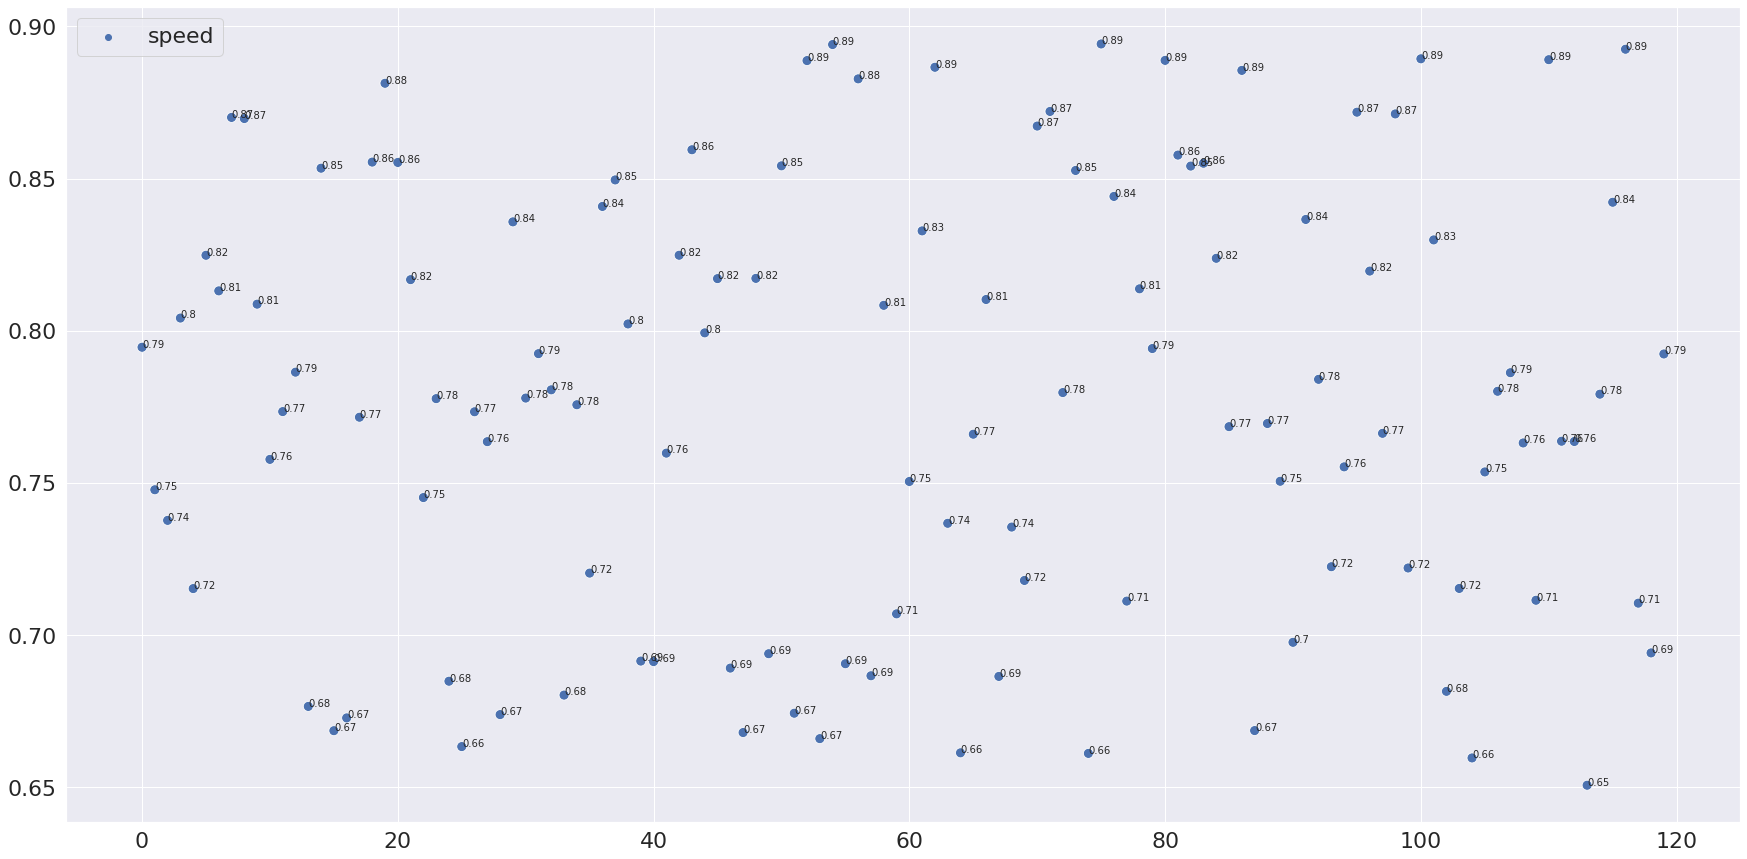

In [94]:
print(f'opponents num: {len(opp_weights)}')
opp_weights = opp_weights.T
opp_weights_dict = {}
for param_idx, param_name in param_dict.items():
    if param_name in ("speed", "collision thres"):
        opp_weights_dict[param_name] = opp_weights[int(param_idx)]
opp_weights_df = pd.DataFrame(opp_weights_dict)
sns.scatterplot(data=opp_weights_df, s=100)

for name in opp_weights_df.columns:
    label_point(opp_weights_df.index.to_series(), opp_weights_df[name], opp_weights_df[name], plt.gca())

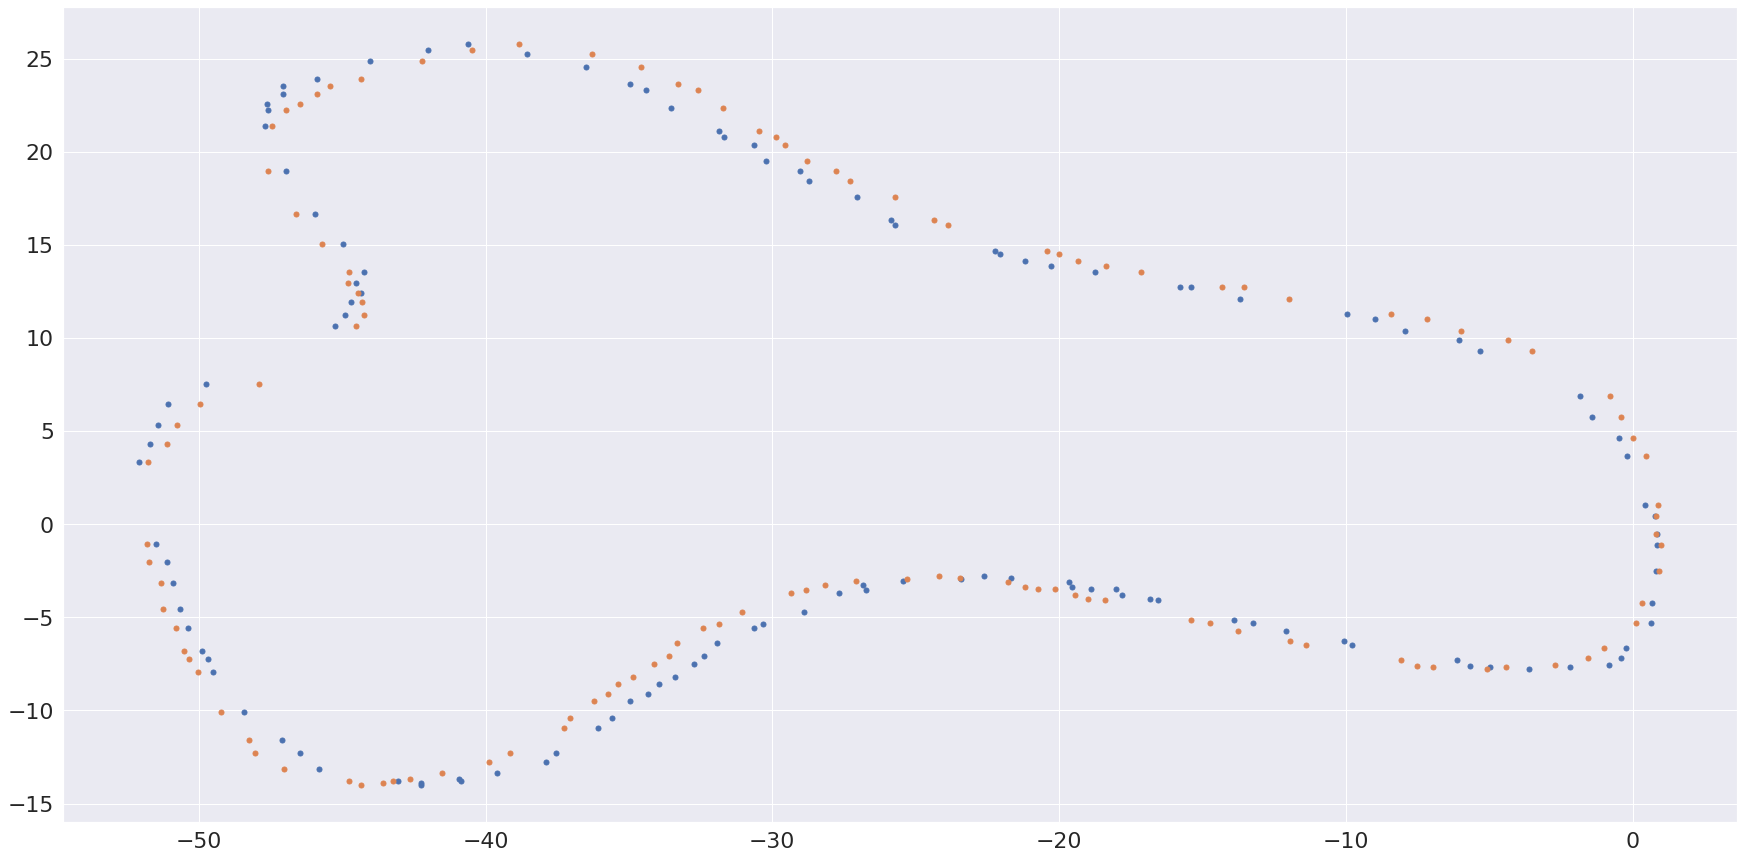

In [95]:
ego_start_pose = scenario_data['ego_start_pose'][:, :2].T
opp_start_pose = scenario_data['opp_start_pose'][:, :2].T
fig, ax = plt.subplots()
ax.plot(opp_start_pose[0], ego_start_pose[1], 'o', markersize=5.0)
ax.plot(ego_start_pose[0], ego_start_pose[1], 'o', markersize=5.0)
plt.show()

# Show Score

In [96]:
objective_dict = {0: 'progress', 1: 'agressive', 2:'safety'}
show_objective = {0, 1, 2}

objective_dict = {0: 'progress', 1:'safety'}
show_objective = {0, 1}
objective_num = 2

7.944898462918318


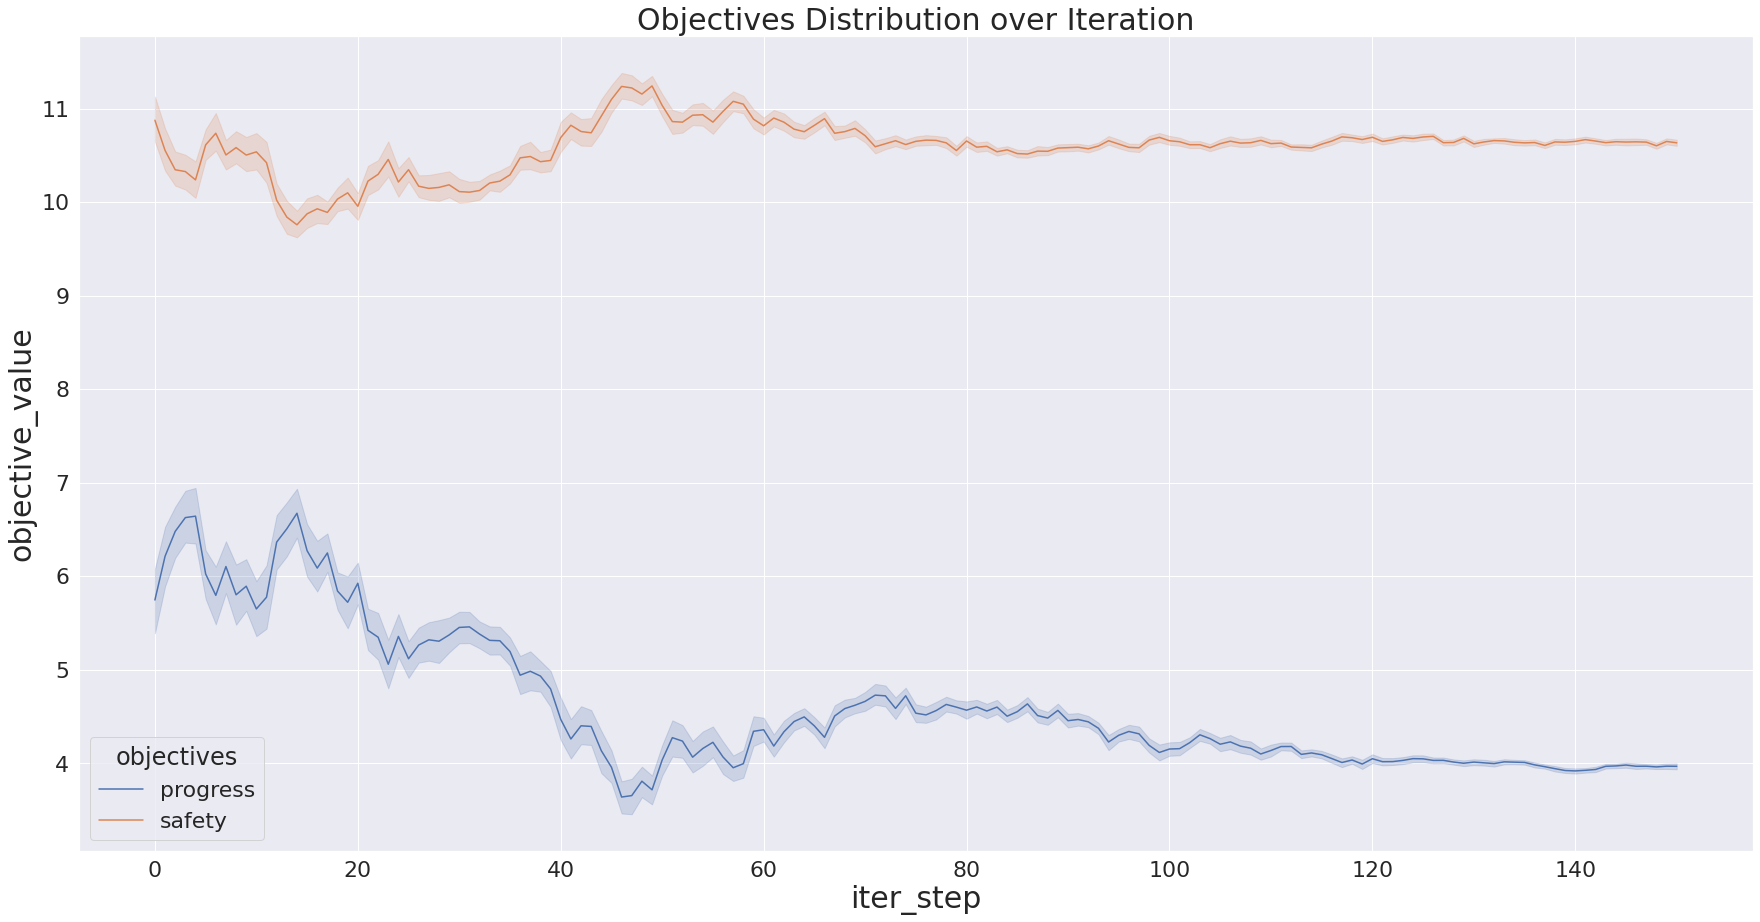

In [97]:
score_series = score_data['scores'].reshape(-1, worker_num, objective_num)  # (worker*n, objective_num)
print(np.min(score_series[:, :, 1]))
df = {'iter_step':[], 'objectives':[], 'objective_value':[]}
for iter_step in range(0, score_series.shape[0]):
    df['iter_step'].extend([iter_step] * worker_num * len(show_objective))
    for key_i, obj in objective_dict.items():
        if key_i in show_objective:
            df['objectives'].extend([obj]*worker_num)
            df['objective_value'].extend(list(score_series[iter_step, :, key_i]))

df = pd.DataFrame(data=df)
# sns.lineplot(data=df, x='iter_step', y='objective_value', hue='objectives', style='objectives')
sns.lineplot(data=df, x='iter_step', y='objective_value', hue='objectives')
plt.xlabel('iter_step', fontsize=font_size)
plt.ylabel('objective_value', fontsize=font_size)
plt.title('Objectives Distribution over Iteration', fontsize=font_size)
plt.show()

# Show overtake and crash

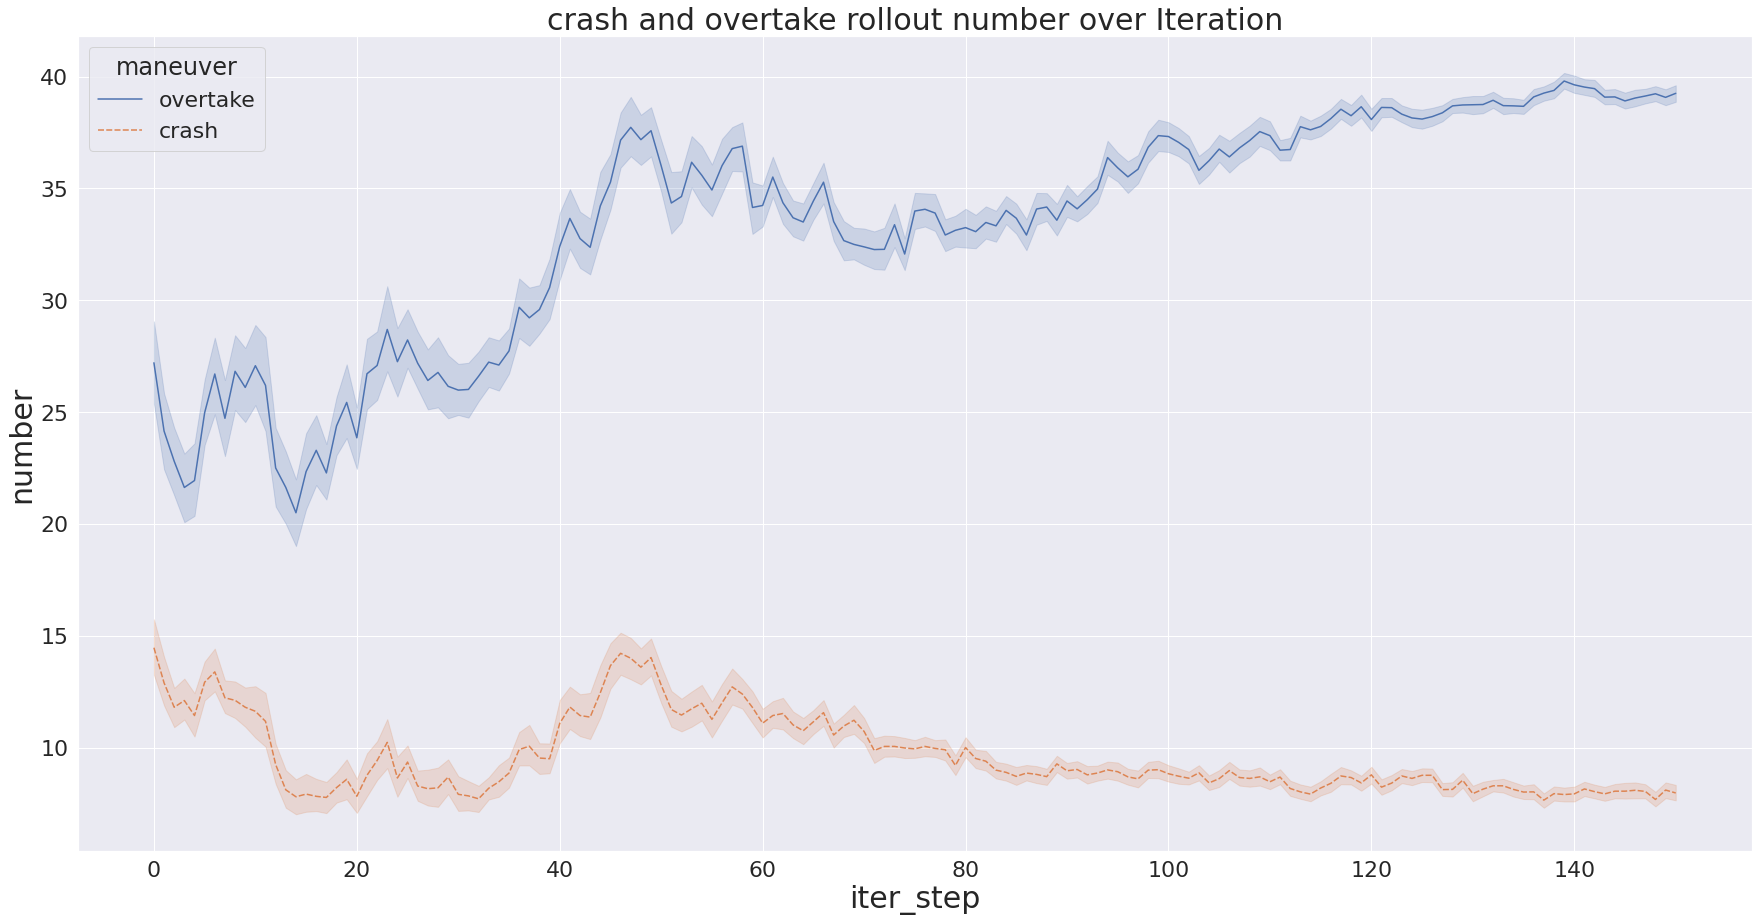

In [98]:
overtake_series = score_data['overtake'].reshape(-1, worker_num)  # (worker*n, objective_num)
crash_series = score_data['crash'].reshape(-1, worker_num)  # (worker*n, objective_num)
df = {'iter_step':[], 'maneuver':[], 'number':[]}
for iter_step in range(0, crash_series.shape[0]):
    df['iter_step'].extend([iter_step] * worker_num * 2)
    df['maneuver'].extend(['overtake']*worker_num)
    df['number'].extend(list(overtake_series[iter_step, :]))
    df['maneuver'].extend(['crash']*worker_num)
    df['number'].extend(list(crash_series[iter_step, :]))
df = pd.DataFrame(data=df)
sns.lineplot(data=df, x='iter_step', y='number', hue='maneuver', style='maneuver')
plt.xlabel('iter_step', fontsize=font_size)
plt.ylabel('number', fontsize=font_size)
plt.title('crash and overtake rollout number over Iteration', fontsize=font_size)
plt.show()

# weights covaniance

# Show correlation

In [99]:
seeds_w_score = {}
for object_idx in show_objective:
    seeds_w_score[objective_dict[object_idx]] = all_scores[object_idx]
for param_idx, param_name in param_dict.items():
    seeds_w_score[param_name] = all_seeds[int(param_idx)]

seeds_w_score_df = pd.DataFrame(seeds_w_score)
seeds_w_score_df.head()

,progress,safety,speed,max_curvature,length,similarity,follow_optim,abs_speed_reward,opponent_collision
0,3.996425,11.821040,0.827313,6.136863,5.598759,5.176821,5.075167,5.447725,5.708322
1,5.810521,11.068910,0.798255,5.337654,5.372503,5.908845,4.519089,5.867918,5.255484
2,6.766607,10.054991,0.779678,5.412780,4.803171,5.961217,4.971515,6.271617,5.200390
3,4.408662,11.384922,0.821989,4.509282,5.321738,5.563282,5.071271,5.369080,4.948231
4,5.663380,10.556897,0.798016,5.344240,6.159867,5.591304,6.408529,5.421777,5.931438


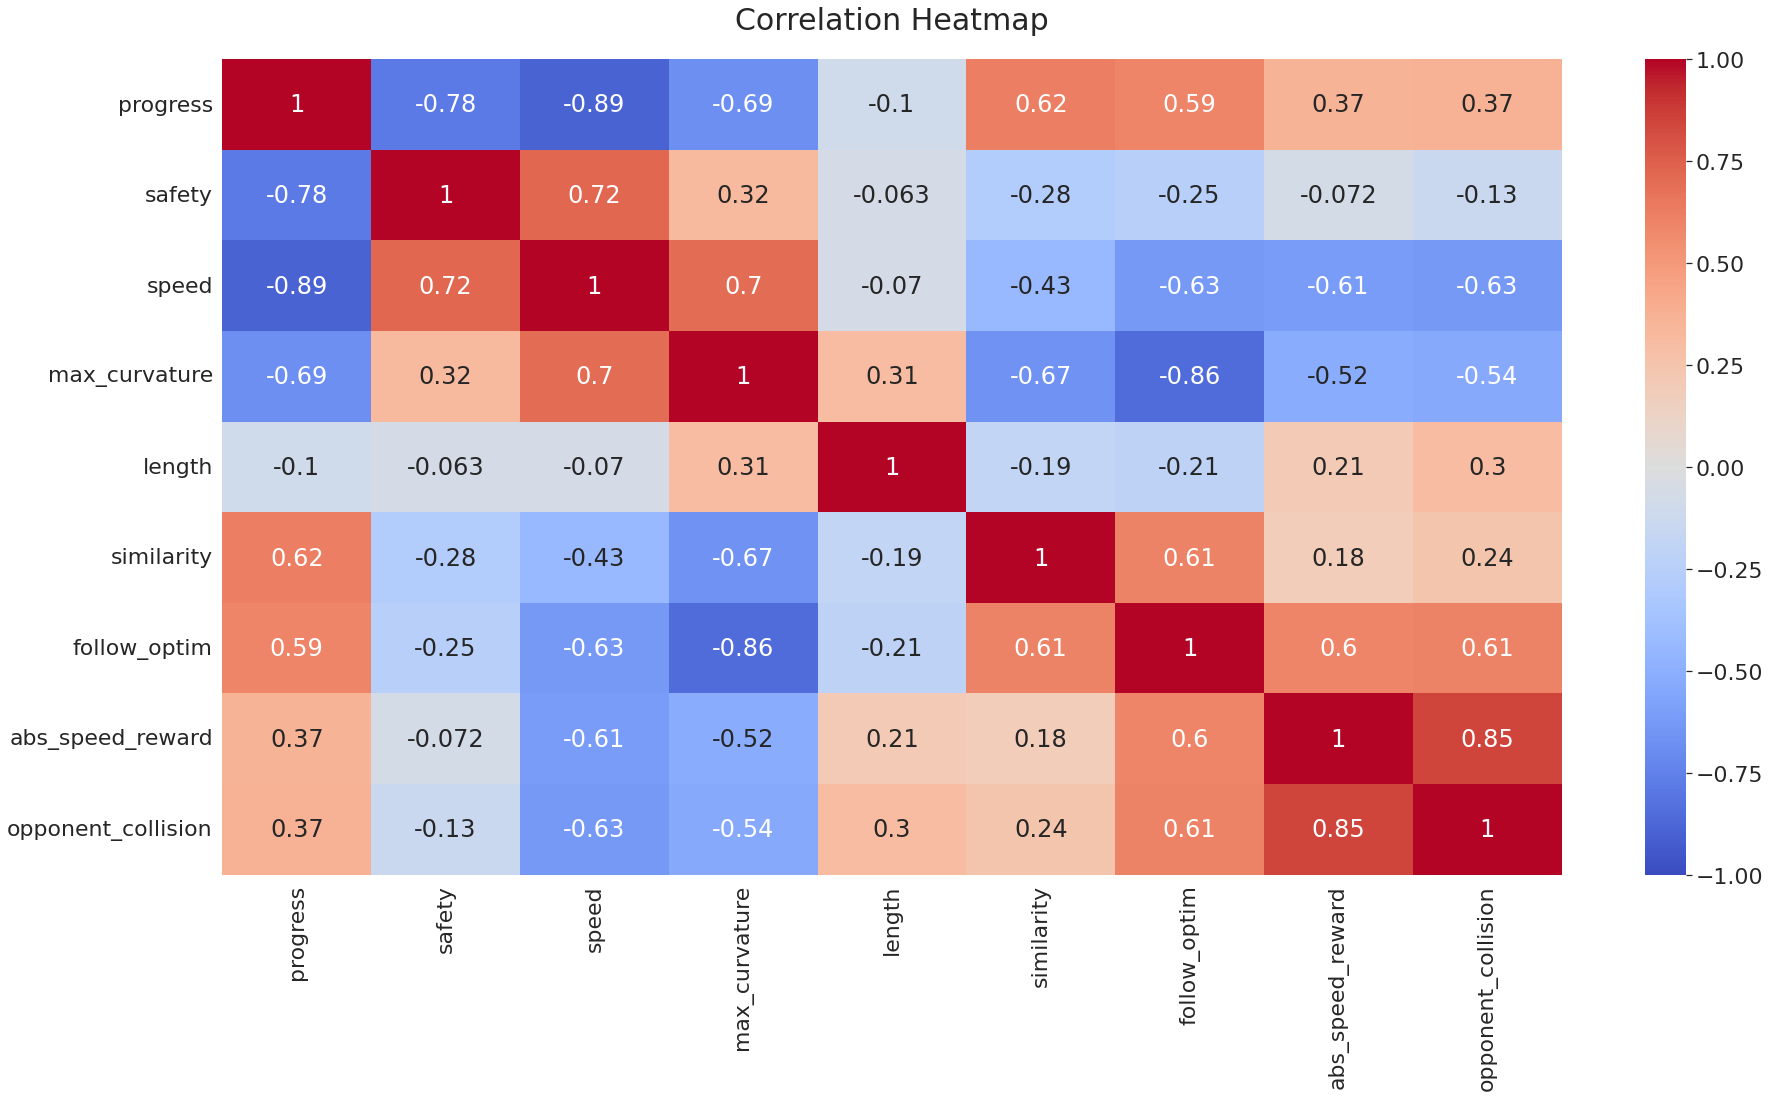

In [100]:
sns.set(font_scale=2.0)
heatmap = sns.heatmap(seeds_w_score_df.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':30}, pad=30);
plt.show()

# Show variance over the iteration

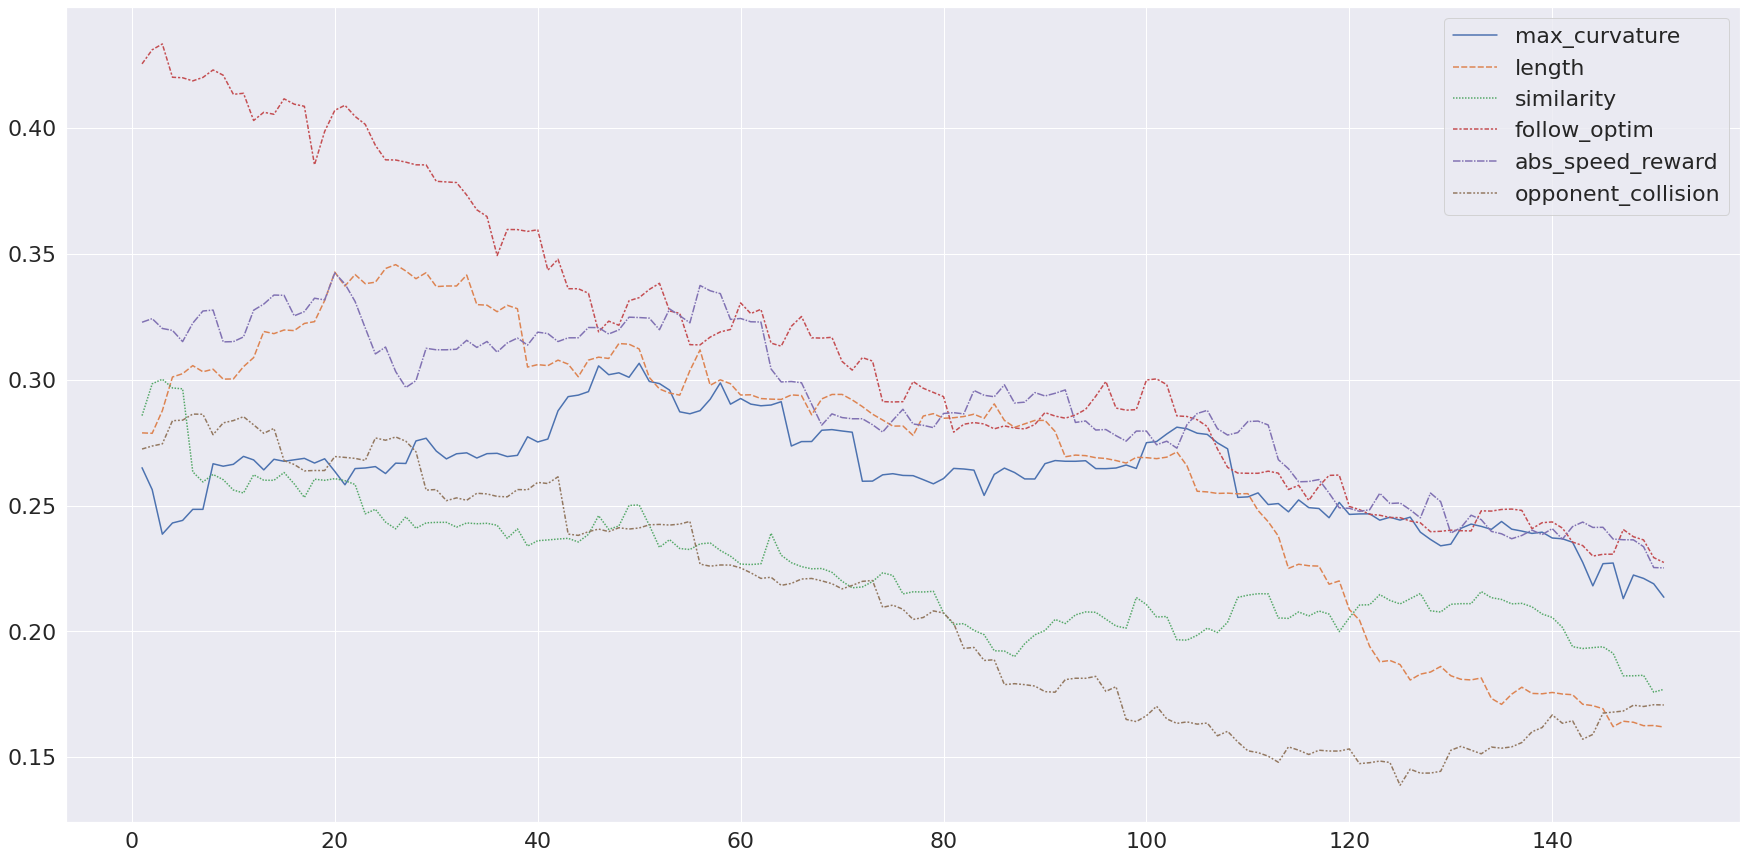

In [114]:
# worker_num
# series is made up from indexes and data, can also give a name(column) 
# https://sparkbyexamples.com/pandas/pandas-combine-two-series-into-dataframe/
# https://pandas.pydata.org/docs/user_guide/indexing.html
worker_num = 100
variance_series = []
for i in range(score_series.shape[0]):
    # tmp = seeds_w_score_df.loc[i:i+worker_num, list(param_dict.values())].var()
    tmp = seeds_w_score_df.loc[i:i+worker_num, list(param_dict.values())[1:]].var()
    # tmp = seeds_w_score_df.loc[i:i+worker_num, ['progress']].mean()
    # print(tmp)
    # tmp = seeds_w_score_df.loc[i:i+worker_num, seeds_w_score_df.columns].mean()
    tmp.name = score_series.shape[0]-i
    variance_series.append(tmp)

variance_df = pd.concat(variance_series[::-1], axis=1).T
# print(list(objective_dict.values()))
# print(variance_df.columns)
# variance_df.drop(columns = list(objective_dict.values()))
# print(variance_df.head())
sns.lineplot(data=variance_df)
plt.show()

# Show single component relation

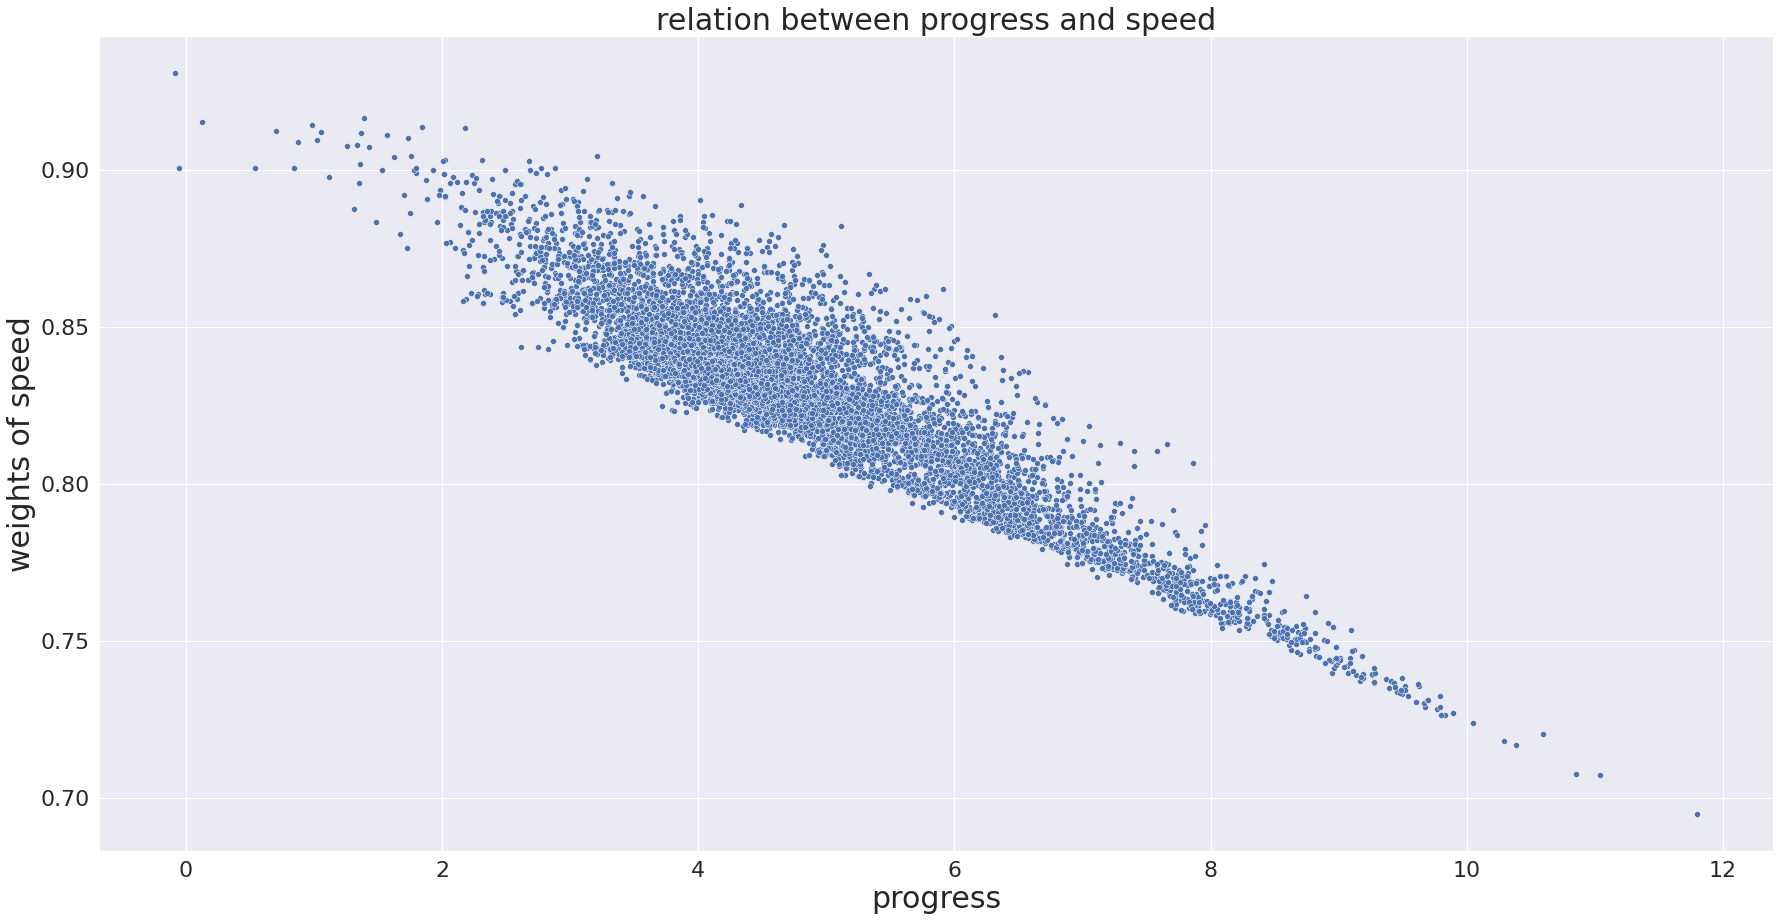

In [115]:
obj = 'progress'
# obj = 'safety'
comp = param_dict['0']
plt.figure()
sns.scatterplot(data=seeds_w_score_df, x=obj, y=comp)
plt.xlabel(obj, fontsize=font_size)
plt.ylabel(f'weights of {comp}', fontsize=font_size)
plt.title(f'relation between {obj} and {comp}', fontsize=font_size)
plt.show()

# Show all seeds

len of pareto front is 15100


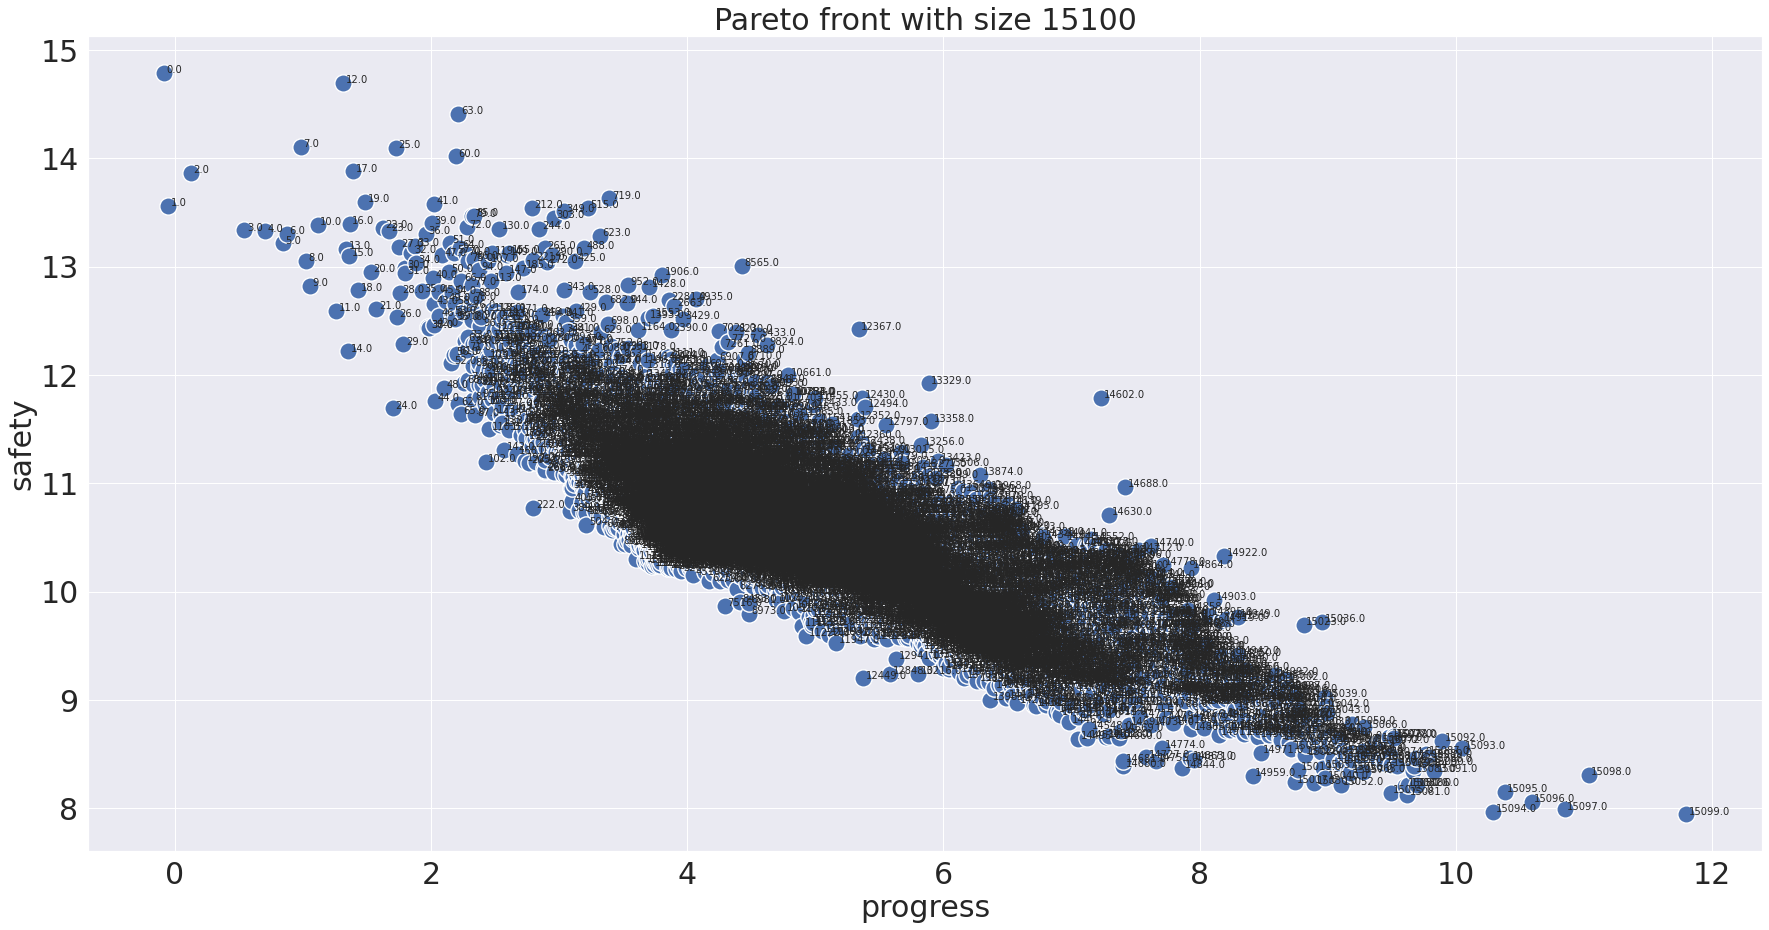

In [126]:
objective_score = []
distance = []
pareto_arr = []
# for param in sorted(optim.pareto_front(), key=lambda p: p.losses[0]):
#     objective_score.append(param.losses)
#     param_arr = paramsDict2Array(param.value, param_name_list)
#     pareto_arr.append(param_arr)
#     distance.append(np.linalg.norm(param_arr))
    # print(f"{param_arr} with objectives {param.losses}")

pareto_size = 100000
for i in np.argsort(all_scores.T[:, 0]):
    pareto_size -= 1
    objective_score.append(all_scores.T[i])
    pareto_arr.append(all_seeds.T[i])
    if pareto_size<0:
        break
    

pareto_arr = np.array(pareto_arr)
pareto_arr = pareto_arr.T
objective_score = np.array(objective_score).T
print(f'len of pareto front is {len(pareto_arr.T)}')

## draw
data = {'progress': objective_score[0], 'safety': objective_score[1]}
data_df = pd.DataFrame(data)
sns.set(font_scale=2.0)
# g = sns.scatterplot(data=data_df, x='progress', y='safety', hue='Euclidean distance', legend='brief', s=300)
g = sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=300)
label_point(data_df['progress'], data_df['safety'], data_df.index.to_series() ,plt.gca())
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress', fontsize=font_size)
plt.ylabel('safety', fontsize=font_size)
plt.title(f'Pareto front with size {len(pareto_arr.T)}', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.show()

# Show Pareto Front

len of pareto front is 49


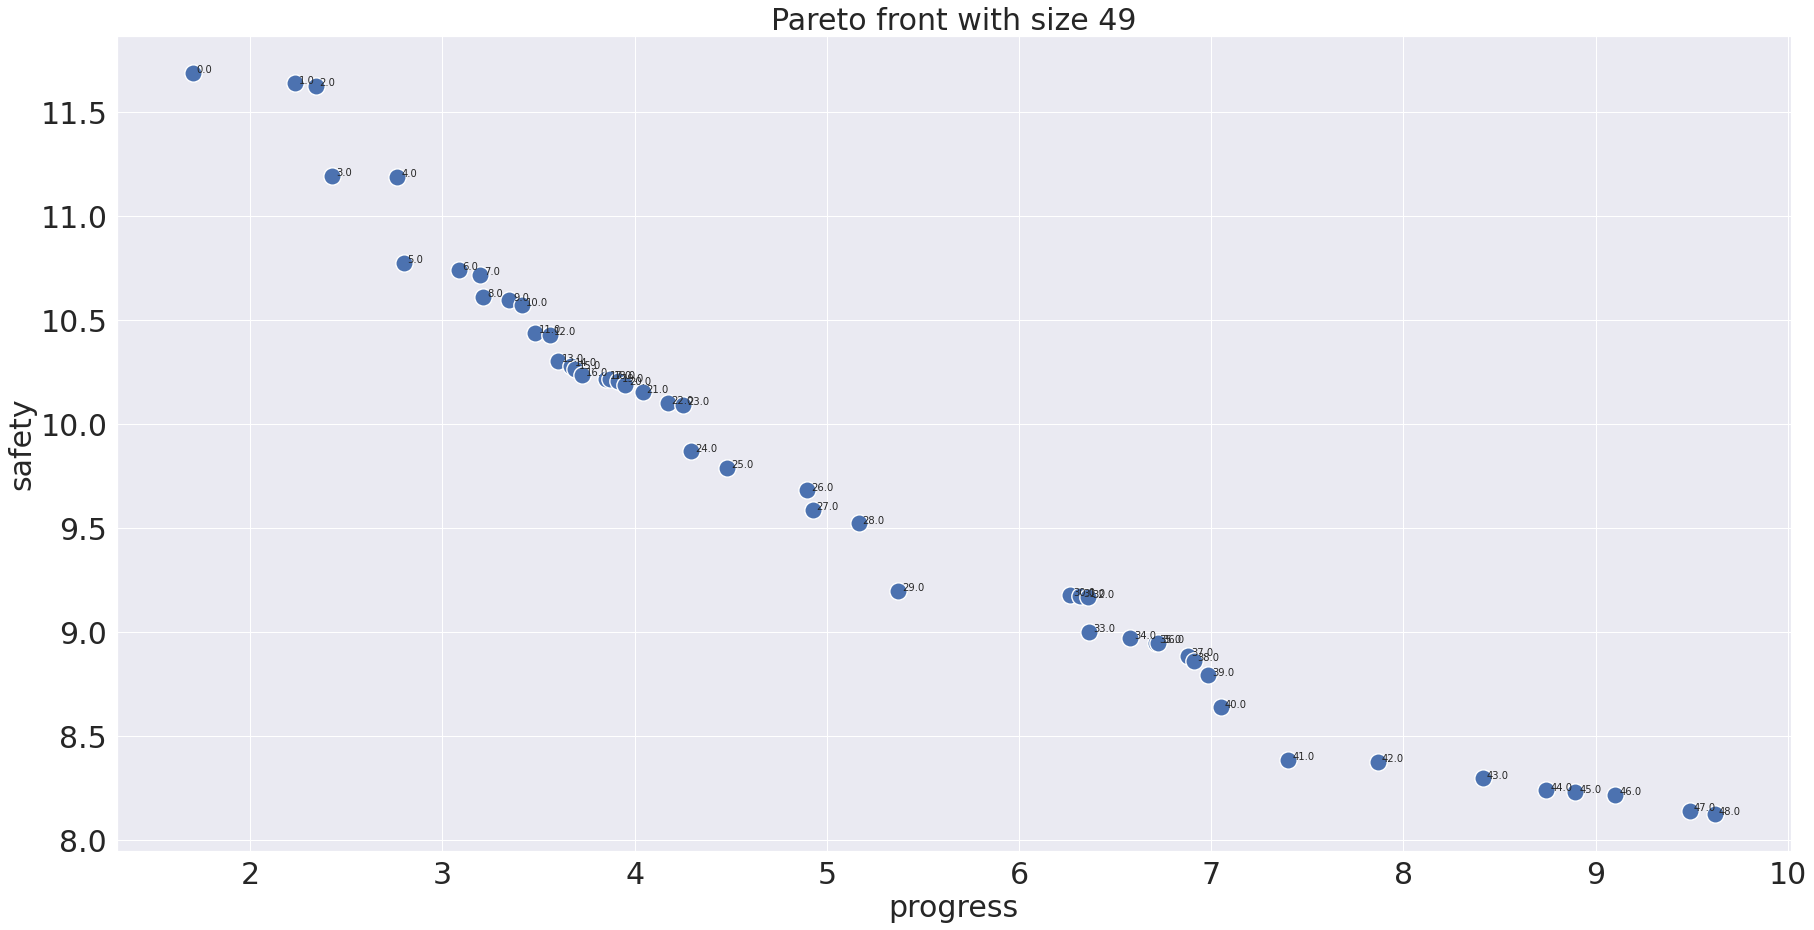

In [117]:
objective_score = []
distance = []
pareto_arr = []
for param in sorted(optim.pareto_front(), key=lambda p: p.losses[0]):
    objective_score.append(param.losses)
    param_arr = paramsDict2Array(param.value, param_name_list)
    pareto_arr.append(param_arr)
    distance.append(np.linalg.norm(param_arr))
    # print(f"{param_arr} with objectives {param.losses}")

# pareto_size = 10000
# for i in np.argsort(all_scores.T[:, 0]):
#     pareto_size -= 1
#     objective_score.append(all_scores.T[i])
#     pareto_arr.append(all_seeds.T[i])
#     if pareto_size<0:
#         break
    

pareto_arr = np.array(pareto_arr)
pareto_arr = pareto_arr.T
objective_score = np.array(objective_score).T
print(f'len of pareto front is {len(pareto_arr.T)}')

## draw
data = {'progress': objective_score[0], 'safety': objective_score[1]}
data_df = pd.DataFrame(data)
sns.set(font_scale=2.0)
# g = sns.scatterplot(data=data_df, x='progress', y='safety', hue='Euclidean distance', legend='brief', s=300)
g = sns.scatterplot(data=data_df, x='progress', y='safety', legend='brief', s=300)
label_point(data_df['progress'], data_df['safety'], data_df.index.to_series() ,plt.gca())
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress', fontsize=font_size)
plt.ylabel('safety', fontsize=font_size)
plt.title(f'Pareto front with size {len(pareto_arr.T)}', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.show()

# Show distribution of Pareto front

pareto num: 49


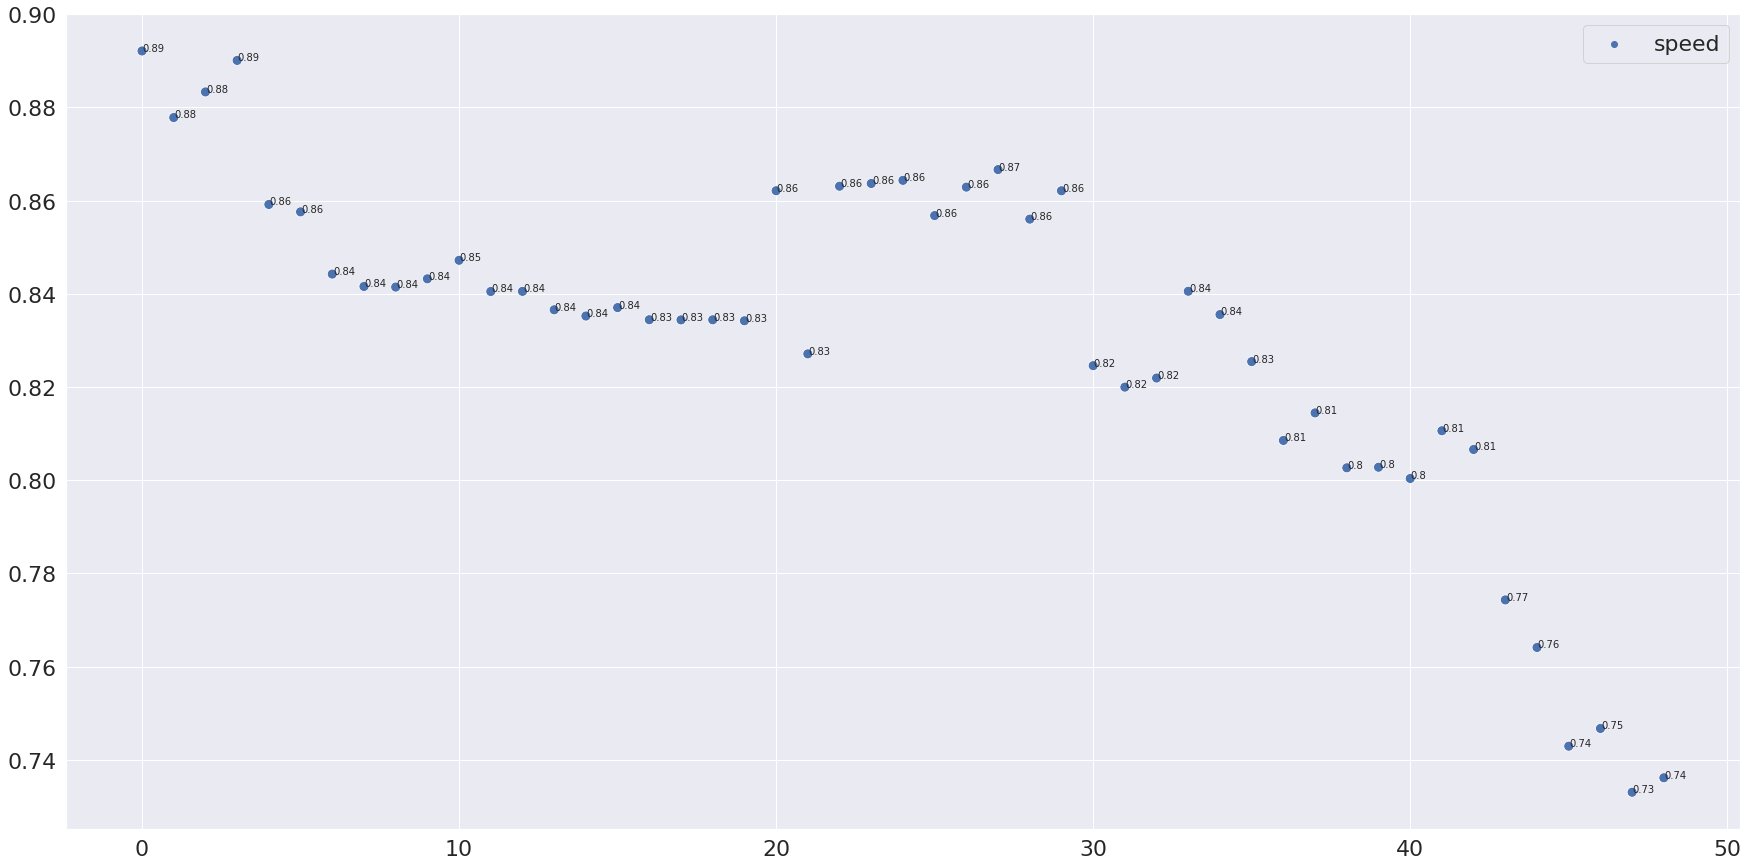

In [118]:
pareto_num = len(pareto_arr.T)
print(f'pareto num: {pareto_num}')

pareto_weights_dict = {}
show_param_names = param_dict['0']
for param_idx, param_name in param_dict.items():
    if param_name in show_param_names:
        pareto_weights_dict[param_name] = pareto_arr[int(param_idx)]
pareto_weights_df = pd.DataFrame(pareto_weights_dict)
sns.scatterplot(data=pareto_weights_df, s=100)

for name in pareto_weights_df.columns:
    label_point(pareto_weights_df.index.to_series(), pareto_weights_df[name], pareto_weights_df[name], plt.gca())

# Show PCA of Pareto Front

In [275]:
# objective_score = []
# distance = []
# weights = []
# for param in sorted(optim.pareto_front(), key=lambda p: p.losses[0]):
#     objective_score.append(param.losses)
#     distance.append(np.linalg.norm(param.value))
#     weights.append(param.value)
# objective_score = np.array(objective_score).T
# print(f'len of pareto front is {len(distance)}')
#
# pca = PCA(n_components=2)
# pca_results = pca.fit_transform(weights)
# plt.rcParams["figure.figsize"] = (15,15)
# ## draw
# data = {'progress': objective_score[0], 'safety': objective_score[1], 'Euclidean distance': np.round(distance, 1),
#         'PC_1': pca_results[:, 0], 'PC_2': pca_results[:, 1]}
# data_df = pd.DataFrame(data)
# sns.scatterplot(data=data_df, x='PC_1', y='PC_2', hue='progress', s=100)
# # plt.legend(title='distance', fontsize=font_size)
# plt.xlabel('PC_1', fontsize=font_size)
# plt.ylabel('PC_2', fontsize=font_size)
# plt.title(f'Pareto front PCA of progress', fontsize=font_size)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
# plt.show()

In [276]:
# sns.scatterplot(data=data_df, x='PC_1', y='PC_2', hue='safety', s=100)
# # plt.legend(title='distance', fontsize=font_size)
# plt.xlabel('PC_1', fontsize=font_size)
# plt.ylabel('PC_2', fontsize=font_size)
# plt.title(f'Pareto front PCA of safety', fontsize=font_size)
# plt.xticks(fontsize=font_size)
# plt.yticks(fontsize=font_size)
# plt.show()

# Get more point near Pareto Front

In [277]:
# seeds_w_score_df
print(all_scores.shape)
print(all_seeds.shape)
print(pareto_arr.shape)
print(objective_score.shape)

(2, 12100)
(7, 12100)
(7, 35)
(2, 35)


/home/zzjun/Documents/objective_space/obj_space_planning/es_src/data/23/near_pareto_idx.npz
near pareto front dist threshold is 0.2, near pareto front point number is 571


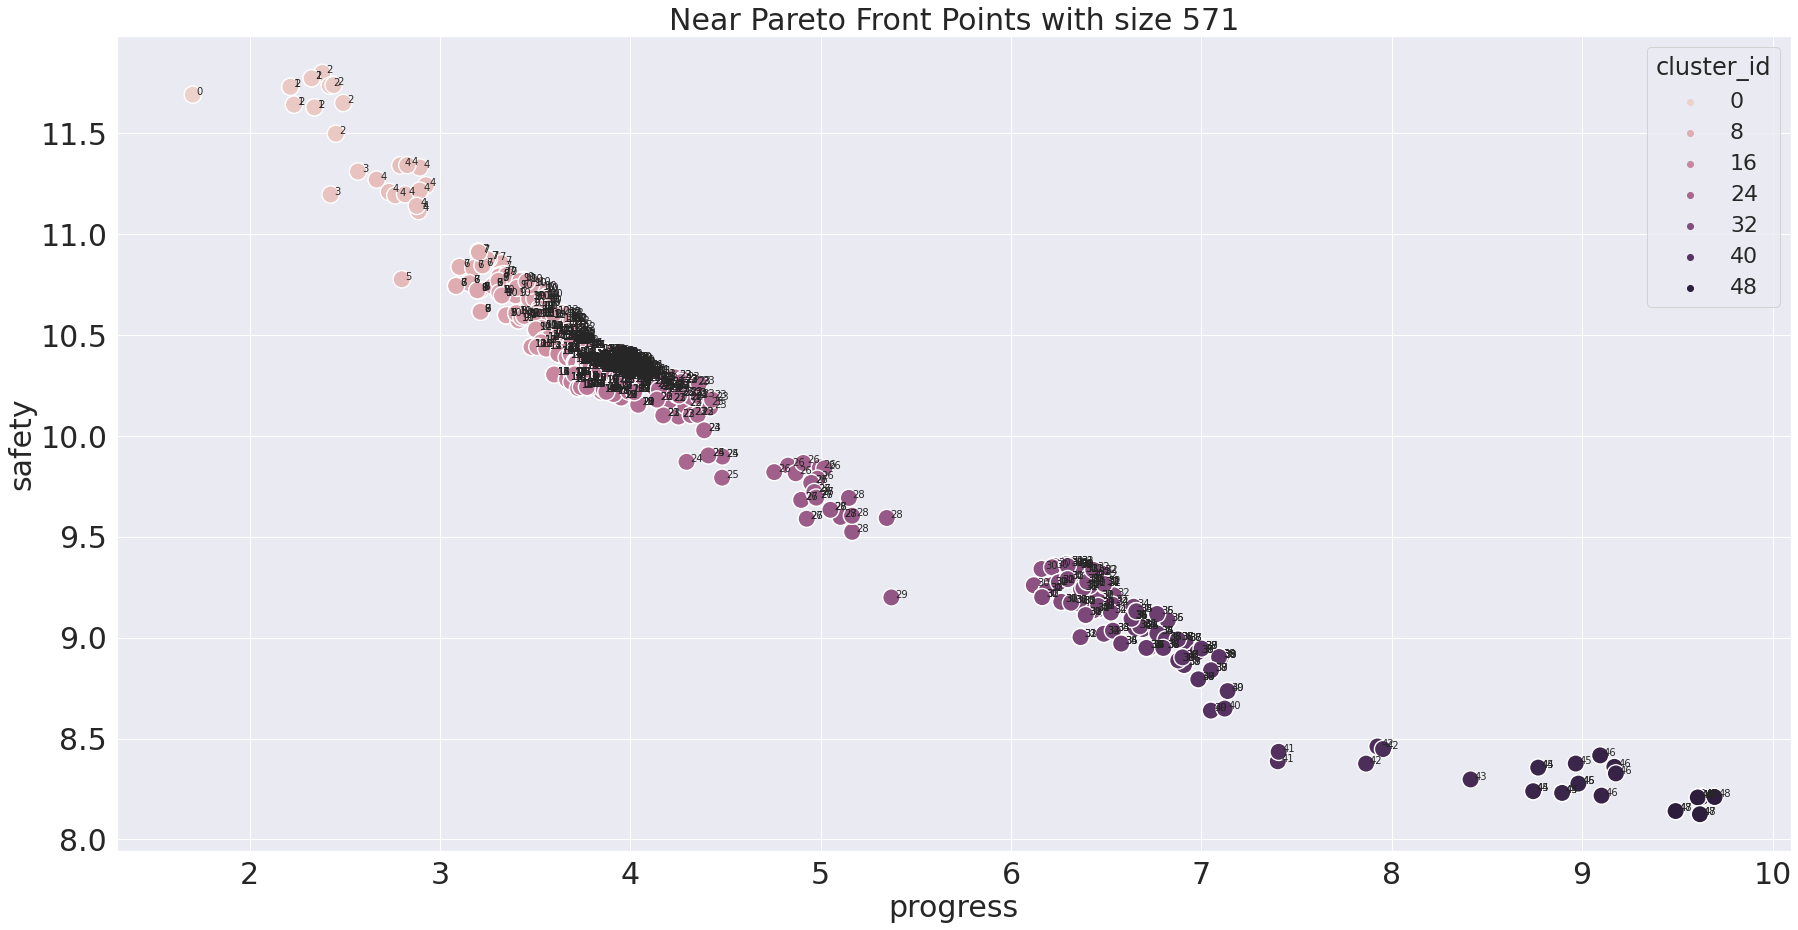

In [120]:
dist_thres = 0.2
near_idx = []
near_dict = {}
for i, pareto_p in enumerate(objective_score.T):
    # (2, )
    dist = np.linalg.norm(all_scores.T - pareto_p, axis=1)  # (9600, )
    tmp = np.nonzero(dist<dist_thres)[0]
    near_idx.extend(tmp)
    near_dict[i] = []
    near_dict[i].append(tmp)
near_idx = np.array(near_idx)
np.savez(os.path.join(data_module, str(run), 'near_pareto_idx.npz'), near_idx=near_idx)
print(os.path.join(data_module, str(run), 'near_pareto_idx.npz'))
near_idx = np.unique(near_idx)


near_pareto_seeds = all_seeds.T[near_idx]  # (n, 9)
near_pareto_scores = all_scores.T[near_idx]  # (n, 2)

distance = []
for p, s in zip(near_pareto_seeds, near_pareto_scores):
    distance.append(np.linalg.norm(p))
print(f'near pareto front dist threshold is {dist_thres}, near pareto front point number is {len(near_pareto_seeds)}')
# print(distance)
cluster_num = len(near_dict.keys())
cluster_df = pd.DataFrame(columns=seeds_w_score_df.columns.to_list()+['cluster_id'])
for i in near_dict.keys():
    near_idx = near_dict[i][0]
    aug = seeds_w_score_df.iloc[near_idx]
    aug = aug.assign(cluster_id = [i] * len(near_idx))
    # aug['cluster_id'] = [i] * len(near_idx)
    cluster_df = pd.concat((cluster_df, aug), ignore_index=True)
## draw
sns.set(font_scale=2.0)
g = sns.scatterplot(data=cluster_df, x='progress', y='safety', hue='cluster_id', legend='brief', s=300)
label_point(cluster_df['progress'], cluster_df['safety'], cluster_df['cluster_id'], plt.gca(), is_int=True)
# plt.legend(title='distance', fontsize=font_size)
plt.xlabel('progress', fontsize=font_size)
plt.ylabel('safety', fontsize=font_size)
plt.title(f'Near Pareto Front Points with size {len(distance)}', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.show()

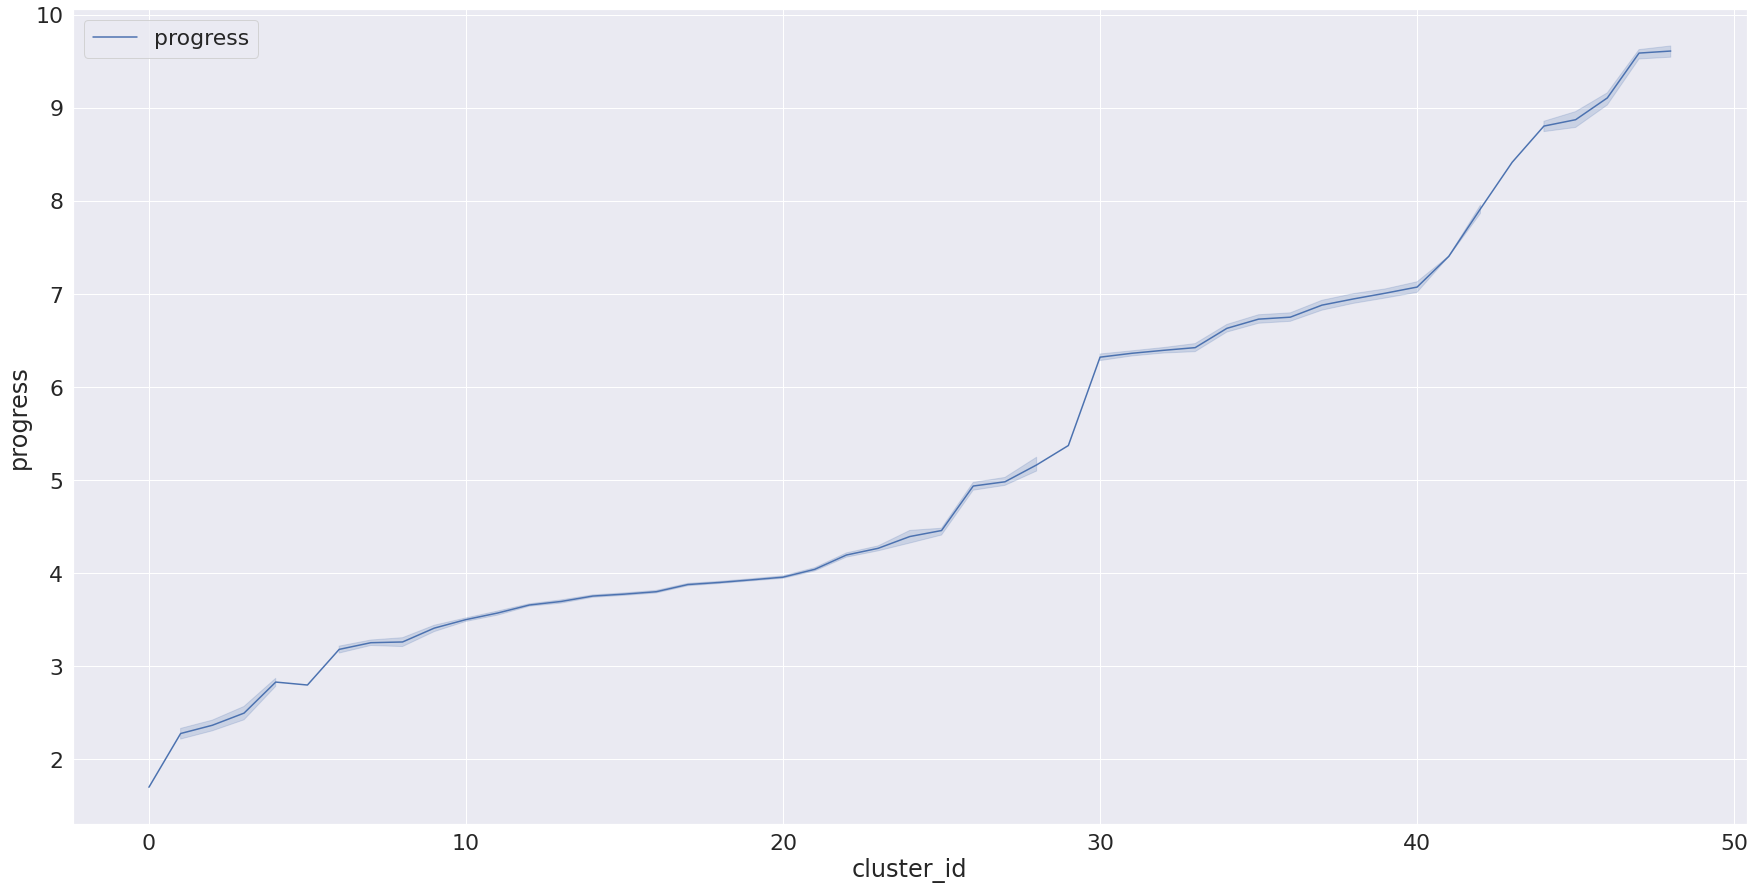

In [121]:
# print(cluster_df.head())
# for i in near_dict.keys():
sns.lineplot(data=cluster_df, x='cluster_id', y='progress', label='progress')
# sns.lineplot(data=cluster_df, x='cluster_id', y='safety', label='safety')
plt.legend()
plt.show()

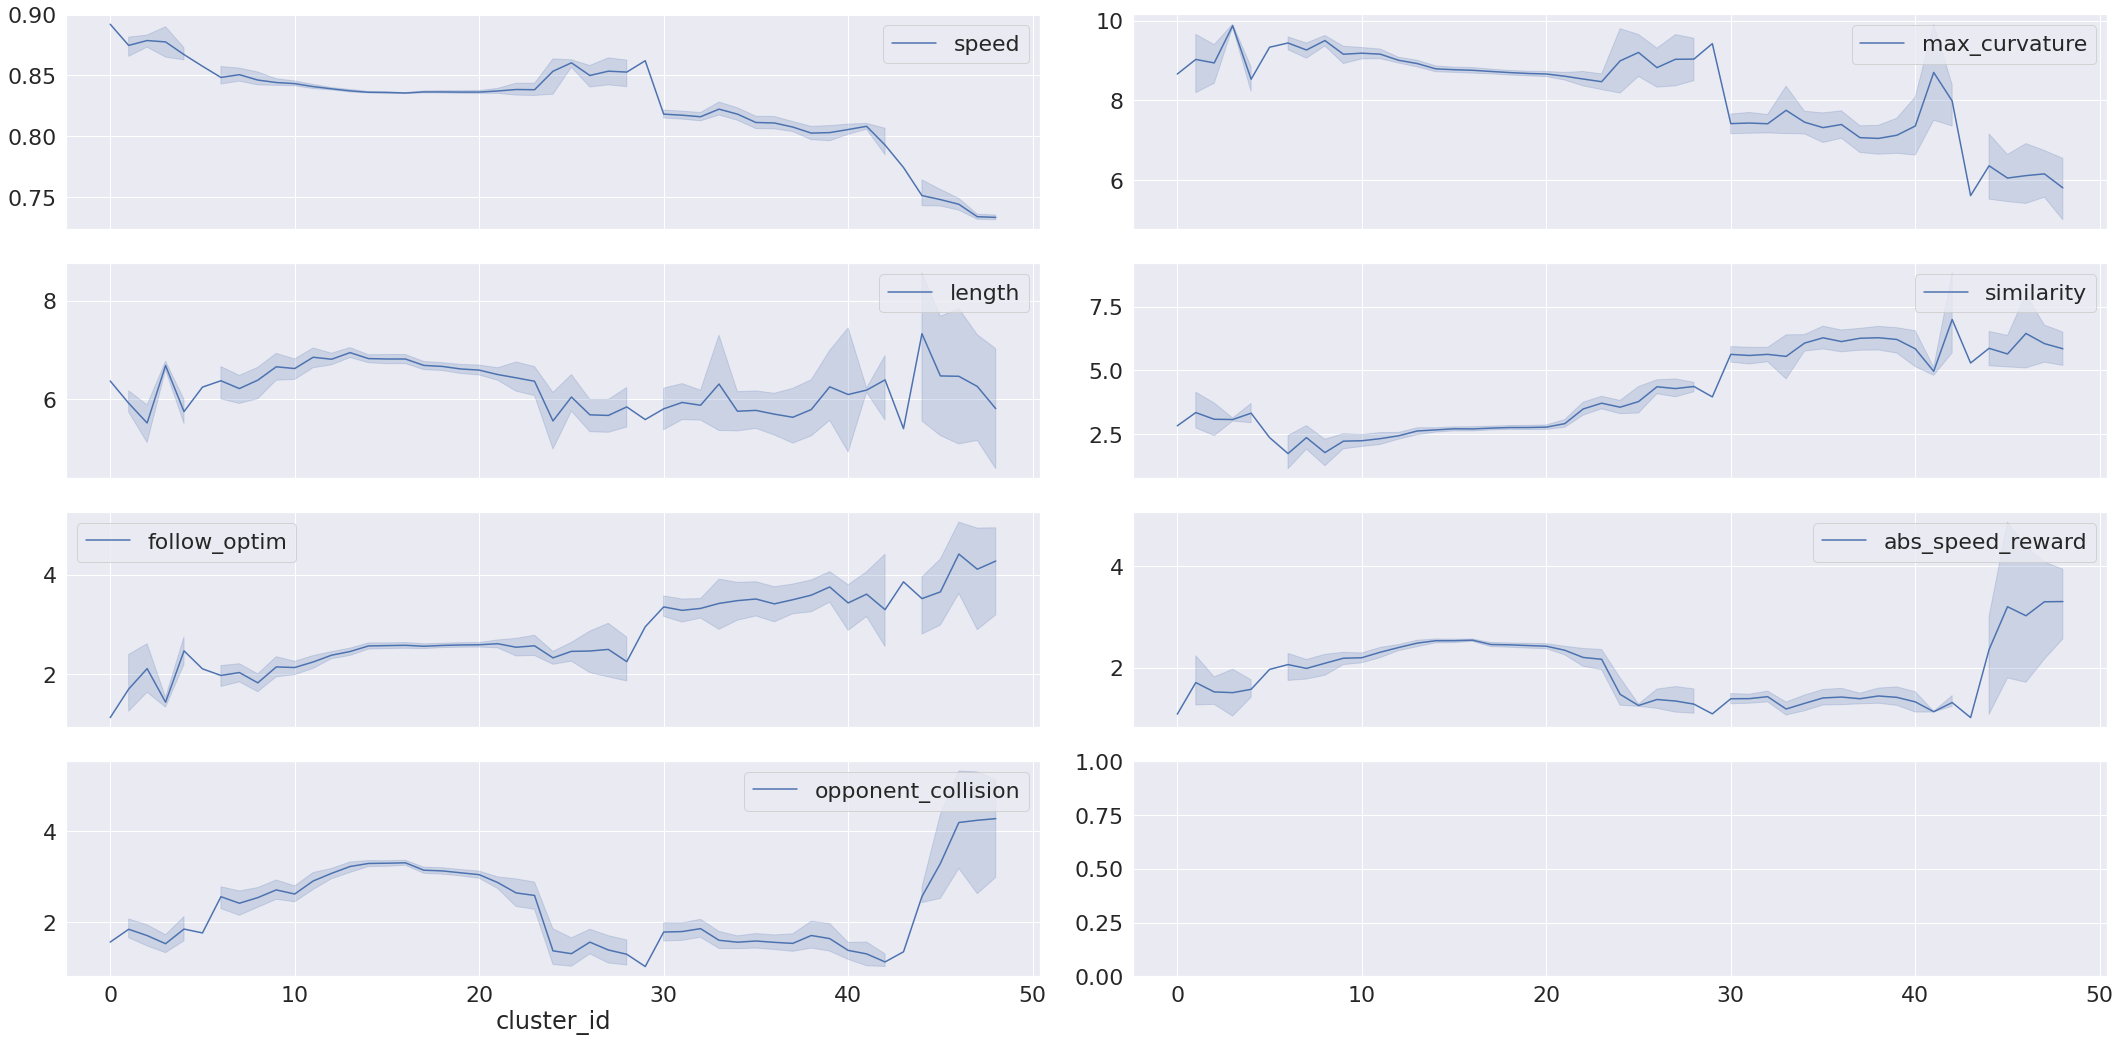

In [122]:
rows = (len(param_dict.keys()) + 1) // 2
fig, axes = plt.subplots(rows, 2, squeeze=False, sharex=True)
for i, param in enumerate(param_dict.values()):
    sns.lineplot(data=cluster_df, x='cluster_id', y=param, ax=axes[i//2][i%2], label=param)
    axes[i//2][i%2].set_ylabel('')
# sns.lineplot(data=cluster_df, x='cluster_id', y='collision thres', ax=axes[0][1])
# sns.lineplot(data=cluster_df, x='cluster_id', y='speed')
# plt.xlabel('iter_step', fontsize=font_size)

# plt.title('crash and overtake rollout number over Iteration', fontsize=font_size)
plt.tight_layout()
# plt.legend()
plt.show()
